In [1]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np

def compute_emd(spike_train_a, spike_train_b):
    # Determine the start and end times for aligning the spike trains
    start_time = min(min(spike_train_a), min(spike_train_b))
    end_time = max(max(spike_train_a), max(spike_train_b))

    bins = np.arange(start_time, end_time + 1, 1)
    aligned_a = np.histogram(spike_train_a, bins=bins)[0]
    aligned_b = np.histogram(spike_train_b, bins=bins)[0]

    # Compute the cumulative distribution functions (CDFs)
    cdf_a = np.cumsum(aligned_a) / len(spike_train_a)
    cdf_b = np.cumsum(aligned_b) / len(spike_train_b)

    # Compute the EMD by integrating the absolute difference between CDFs
    emd = np.sum(np.abs(cdf_a - cdf_b))

    return emd

# Example spike trains
spike_train_a = [0,0.1, 10,10.1]
spike_train_b = [-1,-0.9, 8,7.9, 9,8.9]

# Compute the EMD
emd = compute_emd(spike_train_a, spike_train_b)
print("EMD:", emd)


EMD: 2.3333333333333335


In [ ]:
# downsample 64 --> 32 --> 16, check
# hexagon vs non-hexagonal
# if compute problem go paralell processing
# downsample right before EMD computation only
# post field extraction downsample to 16x16 or 32x32

In [23]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import tkinter as tk
from scipy import signal
from scipy import ndimage
from math import ceil
import cv2
import ot as pot
import itertools
import matplotlib.patches as patches

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# PROJECT_PATH = os.getcwd()
sys.path.append(os.path.dirname(PROJECT_PATH))

from _prototypes.cell_remapping.src.remapping import pot_sliced_wasserstein
from _prototypes.cell_remapping.src.wasserstein_distance import _get_ratemap_bucket_midpoints, single_point_wasserstein

unit_matcher_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(unit_matcher_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab


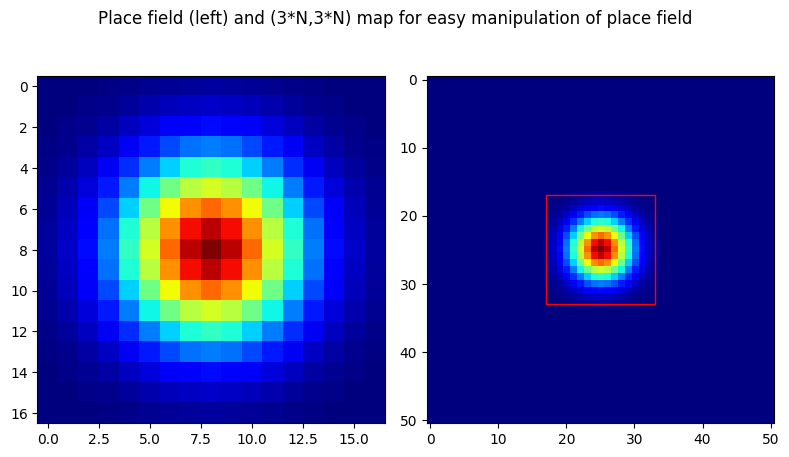

In [3]:
def make_single_field(N=16, stdev=10, shift_row=0, shift_col=0, custom_gauss=None):
    """
    N is kernel size
    """
    if custom_gauss is None:
        k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
        kernel = np.outer(k1d, k1d)
    else:
        kernel = custom_gauss
    single_field = np.zeros((N*3, N*3))
    single_field[N+ceil(N/2)+shift_row, N+ceil(N/2)+shift_col] = 1  
    row, col = np.where(single_field == 1)
    rowend = row[0]+ceil(N/2)
    colend = col[0]+ceil(N/2)
    if colend >= len(single_field):
        colend -= len(single_field)
        colinter = N - colend
    else:
        colinter = N
    if rowend >= len(single_field):
        rowend -= len(single_field)
        rowinter = N - rowend
    else:
        rowinter = N

    # if N % 2 == 0:
    #     single_field[row[0]-ceil(N/2):row[0]+ceil(N/2), col[0]-ceil(N/2):col[0]+ceil(N/2)] = kernel[:rowinter, :colinter]
    # else:
    #     single_field[row[0]-N//2:row[0]+ceil(N/2), col[0]-N//2:col[0]+ceil(N/2)] = kernel[:rowinter, :colinter]

    single_field[row[0]-ceil(N/2):row[0]+N//2, col[0]-ceil(N/2):col[0]+N//2] = kernel
    return single_field

N = 17
stdev = 3
single_field = make_single_field(N, stdev)
k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
kernel = np.outer(k1d, k1d)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,2,1)
ax.imshow(kernel, cmap='jet')
ax = plt.subplot(1,2,2)
ax.imshow(single_field, cmap='jet')
rect = patches.Rectangle((N, N), N-1, N-1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
fig.tight_layout()
fig.suptitle('Place field (left) and (3*N,3*N) map for easy manipulation of place field')
plt.show()



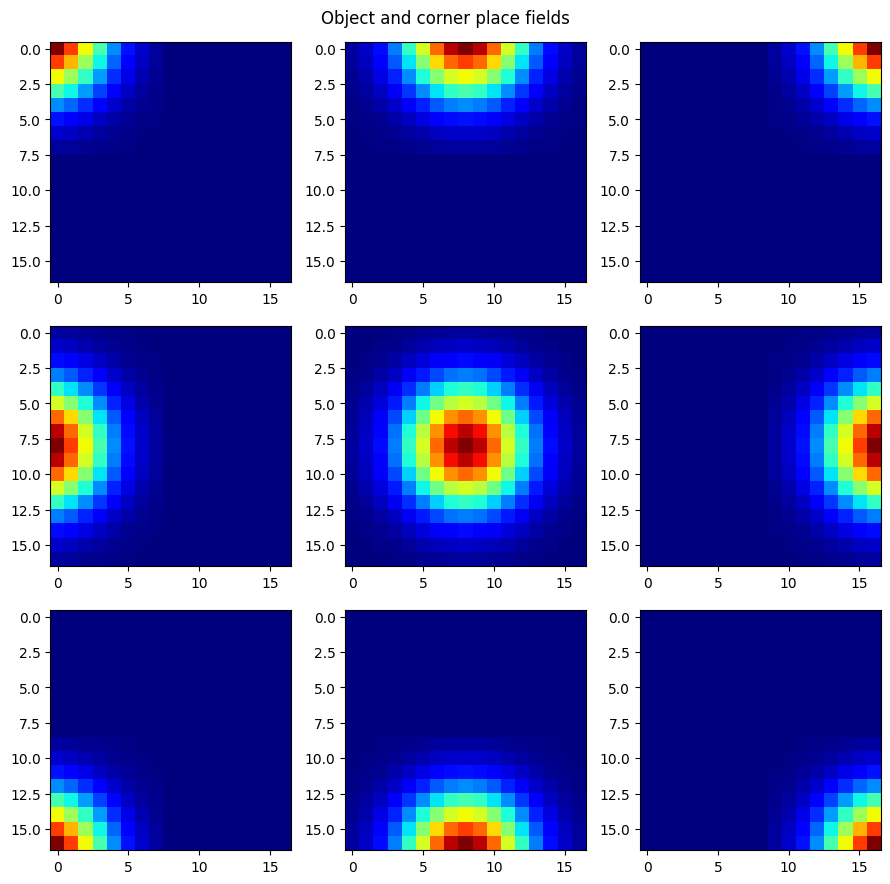

In [4]:
N = 17
stdev = 3
single_field = make_single_field(N, stdev)
top_left = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=-ceil(N/2))
top_middle = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=0)
top_right = make_single_field(N, stdev, shift_row=-ceil(N/2), shift_col=ceil(N/2))
right_middle = make_single_field(N, stdev, shift_row=0, shift_col=ceil(N/2))
bottom_right = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=ceil(N/2))
bottom_middle = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=0)
bottom_left = make_single_field(N, stdev, shift_row=ceil(N/2), shift_col=-ceil(N/2))
left_middle = make_single_field(N, stdev, shift_row=0, shift_col=-ceil(N/2))

to_plot = [top_left, top_middle, top_right, left_middle, single_field, right_middle, bottom_left, bottom_middle, bottom_right]

fig = plt.figure(figsize=(9,9))
axs = []
for i in range(1,10,1):
    ax = plt.subplot(3,3,i)
    ax.imshow(to_plot[i-1][N:N+N,N:N+N], cmap='jet')
    axs.append(ax)

for ax in axs:
    rect = patches.Rectangle((N, N), N, N, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

fig.suptitle('Object and corner place fields')
fig.tight_layout()
plt.show()

object_corner_fields = {
    'top_left': top_left[N:N+N,N:N+N],
    'top_middle': top_middle[N:N+N,N:N+N],
    'top_right': top_right[N:N+N,N:N+N],
    'right_middle': right_middle[N:N+N,N:N+N],
    'bottom_right': bottom_right[N:N+N,N:N+N],
    'bottom_middle': bottom_middle[N:N+N,N:N+N],
    'bottom_left': bottom_left[N:N+N,N:N+N],
    'left_middle': left_middle[N:N+N,N:N+N],
    'center': single_field[N:N+N,N:N+N],
}


In [5]:
def make_gauss (mesh, sxy, rxy, rot):
    x, y = mesh[0] - sxy[0], mesh[1] - sxy[1]
    px = x * np.cos(rot) - y * np.sin(rot)
    py = y * np.cos(rot) + x * np.sin(rot)
    fx = np.exp (-0.5 * (px/rxy[0])**2)
    fy = np.exp (-0.5 * (py/rxy[1])**2)
    return fx * fy

def _interpolate_matrix(matrix, new_size=(257,257), cv2_interpolation_method=cv2.INTER_CUBIC):
    '''
        Interpolate a matrix using cv2.INTER_LANCZOS4.
    '''
    return cv2.resize(matrix, dsize=new_size,
                      interpolation=cv2_interpolation_method)

In [140]:
from scipy.stats import multivariate_normal

N = 16
stdev = 3
px = np.arange(0,N,1)
py = np.arange(0,N,1)
mesh = np.meshgrid(px, py)

rx, ry = 2, 2
sx, sy = int(N/2), int(N/2)
rot = 90
circle_left_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

rx, ry = 2, 2
rot = 0
aggregate_circle_right_ex1 = []
step = 0.5
for i in range(12):
    sx, sy = int(N/2) + i * 0.5, int(N/2)
    circle_right_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 
    aggregate_circle_right_ex1.append(circle_right_ex1)

In [92]:

source_field = circle_left_ex1 
y, x = source_field.shape
height_bucket_midpoints, width_bucket_midpoints = _get_ratemap_bucket_midpoints(([1],[1]), y, x)
buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
source_weights = np.array(list(map(lambda x: source_field[x[0],x[1]], buckets)))
source_weights = source_weights / np.sum(source_weights)
source_coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
pop_shifted_emd = np.zeros(source_field.shape)
pop_shifted_pearson = np.zeros(source_field.shape)
def _sub1(i, j):
    # field = make_single_field(N, stdev, shift_row=row_inds[i],shift_col=col_inds[j])[N:N+N,N:N+N]
    # fld_copy = np.copy(field)
    # fld_copy[:i,:j] = np.nan
    field = np.zeros(source_field.shape)
    field[i,j] = 1
    target_weights = np.array(list(map(lambda y: field[y[0],y[1]], buckets)))
    # if np.isnan(target_weights).any() == True:
    #     print('here')
    # nan_ids = np.where(np.isnan(target_weights))[0]
    # no_nan_ids = np.where(~np.isnan(target_weights))[0]
    # target_weights = target_weights[no_nan_ids]
        
    target_weights = target_weights / np.sum(target_weights)
    target_coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))
    # target_coord_buckets = target_coord_buckets[no_nan_ids]
        
    # print('here')
    emd = pot_sliced_wasserstein(source_coord_buckets, target_coord_buckets, source_weights, target_weights, n_projections=10**2)
    # emd = single_point_wasserstein([i,j],source_field,([1],[1]))
        
    try:
        r, p = pearsonr(source_weights.flatten(), target_weights.flatten())
    except:
        r = np.nan
    return emd, r
def _sub2(i):
    print(i)
    emd_and_r = np.array(list(map(lambda x: _sub1(i, x), np.arange(0,len(pop_shifted_emd)))))
    return emd_and_r[:,0], emd_and_r[:,1]
combined = np.array(list(map(lambda x: _sub2(x), np.arange(0,len(pop_shifted_emd)))))
pop_shifted_emd, pop_shifted_pearson = combined[:,0,:], combined[:,1,:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [255]:
from scipy.spatial.distance import euclidean

def _sample_grid(ids, threshold=3):
    first = True
    valid = []

    # def _sample_pt(point, first, valid):
    for point in ids:
        if first:
            valid.append([point[0], point[1]])
            first = False
        else:                    
            point = [point[0], point[1]]
            if any((euclidean(point, point_ok) < threshold for point_ok in valid)):
            # if any((np.abs(point[0] - point_ok[0]) != np.abs(point[1] - point_ok[1])) for point_ok in valid if ((np.abs(point[0] - point_ok[0] == 1) or np.abs(point[1] - point_ok[1] == 1)))):
                # print('rejected')
                pass
            else:
                valid.append(point)

    return np.array(valid)

                 

In [141]:
r, c = np.where(source_field == np.max(source_field))
object_pos = [r,c]
obj_wass = single_point_wasserstein(object_pos, source_field, ([1],[1]))
quantiles = []

for i in np.arange(0,5,0.1):
    print(i)
    
    non_disk_ids = list(itertools.product(np.arange(0, y), np.arange(0, x)))
    non_disk_grid_sample = _sample_grid(non_disk_ids, i)
    
    resampled_wass = list(map(lambda x: single_point_wasserstein(x, source_field, ([1],[1])), non_disk_grid_sample))
    quantile = (resampled_wass < obj_wass).mean()
    quantiles.append(quantile)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9


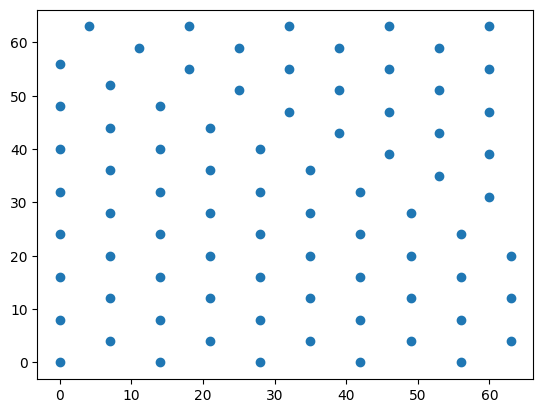

In [280]:
for i in [8]:
    non_disk_ids = list(itertools.product(np.arange(0, 64), np.arange(0, 64)))
    non_disk_grid_sample = _sample_grid(non_disk_ids, i)
    plt.scatter(non_disk_grid_sample[:,0], non_disk_grid_sample[:,1])

(-0.7144709581221619, 15.003890120565398, -0.7000000000000001, 14.7)

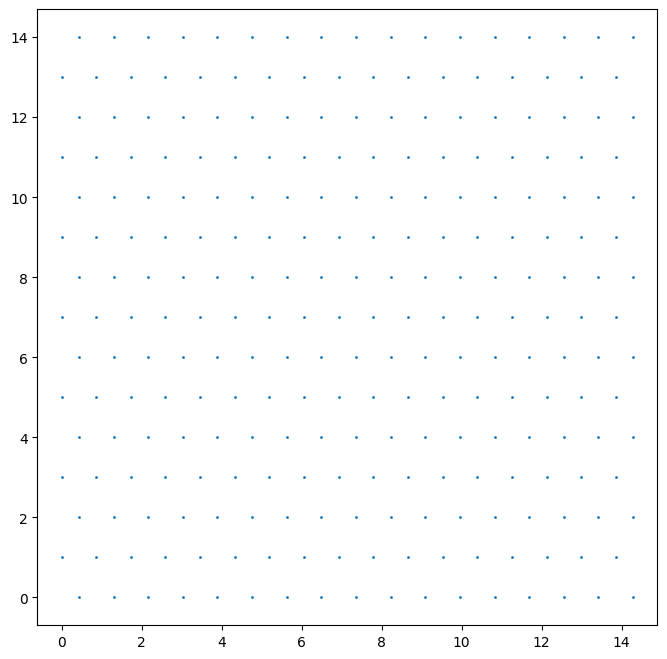

In [489]:
N = 16*16

ratio = np.sqrt(3)/2 # cos(60°) 
N_X = int(np.sqrt(N/ratio))
N_Y = N // N_X
xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
xv = xv * ratio 
xv[::2, :] += ratio/2 
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(xv, yv, s=1)
ax.axis('equal')

0 0 33 29 1.1547005383792517
0 0 33 29 1.1547005383792517


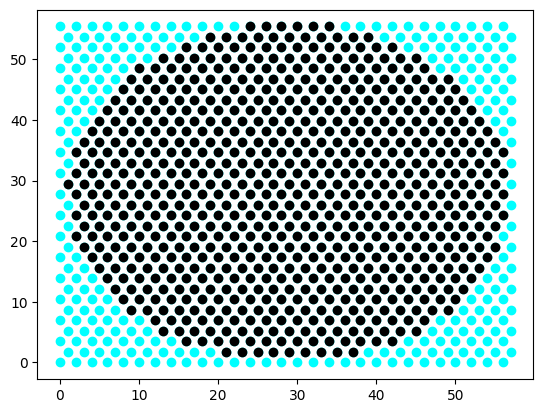

In [960]:
import math
from itertools import chain

def generate_grid(arena_height, arena_width, spacing, is_hexagonal=False, is_cylinder=False):
    if is_hexagonal:
        hexagon_size = spacing / math.sqrt(3)
        num_columns = math.ceil(arena_width / (1.5 * hexagon_size))
        num_rows = math.ceil(arena_height / ((hexagon_size * math.sqrt(3))))

    else:
        num_columns = math.ceil(arena_width / spacing)
        num_rows = math.ceil(arena_height / spacing)
        
   
    if is_cylinder:
        radius_x = arena_width / 2
        radius_y = arena_height / 2
        # offset_x = (arena_width - num_columns * spacing) / 2  # Adjust the x-offset
        # offset_y = (arena_height - num_rows * spacing) / 2   
        # offset_y = offset_x
    else:
        radius_x = None
        radius_y = None
    
    offset_x = offset_y = 0

    if is_hexagonal:
        print(offset_x, offset_y, num_columns, num_rows, hexagon_size)
        columns = range(num_columns)
        rows = range(num_rows)
        grid = list(
            map(
                lambda row: list(
                    map(
                        lambda col: (
                            col * (1.5 * hexagon_size) + offset_x,
                            row * (hexagon_size * math.sqrt(3)) + ((col % 2) * (hexagon_size * math.sqrt(3) / 2)) + offset_y
                        ),
                        filter(
                            lambda col: not radius_x or math.sqrt(
                                ((col * (1.5 * hexagon_size) + offset_x) - radius_x) ** 2 +
                                ((row * (hexagon_size * math.sqrt(3))) + ((col % 2) * (hexagon_size * math.sqrt(3) / 2)) - radius_y) ** 2
                            ) <= radius_x,
                            columns
                        )
                    )
                ),
                rows
            )
        )
    else:
        columns = range(num_columns)
        rows = range(num_rows)
        grid = list(
            map(
                lambda row: list(
                    map(
                        lambda col: (
                            col * spacing + offset_x,
                            row * spacing + offset_y
                        ),
                        filter(
                            lambda col: not radius_x or math.sqrt(
                                ((col * spacing + offset_x) - radius_x) ** 2 +
                                ((row * spacing + offset_y) - radius_y) ** 2
                            ) <= radius_x,
                            columns
                        )
                    )
                ),
                rows
            )
        )

    return list(chain.from_iterable(grid))


def plot_hexagonal_grid(points):
    # Extract x and y coordinates from the grid points
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]
    
    # Plot the hexagonal grid
    plt.scatter(x_coords, y_coords)
    plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio for x and y axes
    plt.show()

# [57.83333333] [55.95]
arena_height = 57.8333333
arena_width = 55.95

pts1 = generate_grid(arena_height, arena_width, 2, is_hexagonal=True, is_cylinder=True)

pts2 = generate_grid(arena_height, arena_width, 2, is_hexagonal=True, is_cylinder=False)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

plt.scatter(pts2[:,1], pts2[:,0],color='cyan')
plt.scatter(pts1[:,1], pts1[:,0], color='k')
plt.show()


In [868]:
pts1.shape

(562, 2)

In [828]:
np.unique(pts1[:,0])

array([ 1.29422863,  3.89230485,  6.49038106,  9.08845727, 11.68653348,
       14.28460969, 16.8826859 , 19.48076211, 22.07883832, 24.67691454,
       27.27499075, 29.87306696, 32.47114317, 35.06921938, 37.66729559,
       40.2653718 , 42.86344802, 45.46152423, 48.05960044, 50.65767665,
       53.25575286, 55.85382907, 58.45190528])

In [816]:
np.unique(pts1[:,1])

array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ,
       17.5, 19. , 20.5, 22. , 23.5, 25. , 26.5, 28. , 29.5, 31. , 32.5,
       34. , 35.5, 37. , 38.5, 40. , 41.5, 43. , 44.5, 46. , 47.5, 49. ,
       50.5, 52. , 53.5, 55. , 56.5, 58. , 59.5, 61. , 62.5, 64. ])

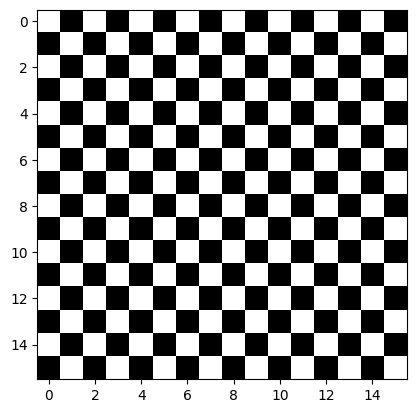

In [223]:
gsample = np.zeros((N,N))
skip = False
for i in range(N):
    for j in range(N):
        if i % 2 != j % 2:
            # if not skip:
            gsample[i, j] = 1
            #     skip = True
            # elif skip:
            #     skip = False

plt.imshow(gsample, cmap='Greys')

In [881]:
rect_quantiles = [[] for i in np.arange(0,0.5,0.1)]
y , x = N, N
jx = 0
noises = []
for j in np.arange(0, 0.5, 0.1):
    noise = np.random.normal(0,j,circle_left_ex1.shape)
    source_field = circle_left_ex1 + noise
    noises.append(noise)
    source_field = np.pad(source_field, 2, mode='linear_ramp')
    r, c = np.where(source_field == np.max(source_field))
    object_pos = [r,c]
    obj_wass = single_point_wasserstein(object_pos, source_field, ([30],[30]))

    for i in np.arange(.1,5,.1):
        
        non_disk_ids = list(itertools.product(np.arange(0, y), np.arange(0, x)))
        # non_disk_grid_sample = _sample_grid(non_disk_ids, i)
        non_disk_grid_sample = generate_grid(30, 30, i, is_hexagonal=False)
        non_disk_grid_sample = np.asarray(non_disk_grid_sample)
        
        resampled_wass = list(map(lambda x: single_point_wasserstein(x, source_field, ([30],[30]), use_pos_directly=True), non_disk_grid_sample))
        quantile = (resampled_wass < obj_wass).mean()
        rect_quantiles[jx].append(quantile)

    jx += 1

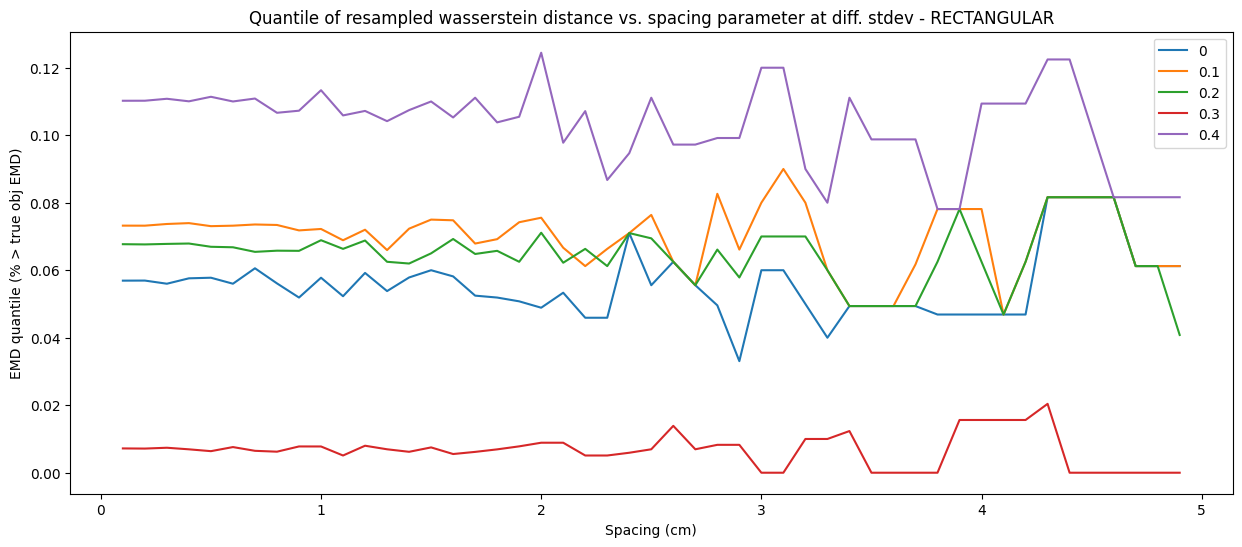

In [882]:
fig = plt.figure(figsize=(15,6))

for x in range(len(rect_quantiles)):
    plt.plot(np.arange(.1,5,.1), rect_quantiles[x], label=[0,.1,.2,.3,.4][x])
plt.legend()
plt.title('Quantile of resampled wasserstein distance vs. spacing parameter at diff. stdev - RECTANGULAR')
plt.xlabel('Spacing (cm)')
plt.ylabel('EMD quantile (% > true obj EMD)')
plt.show()

In [883]:
quantiles = [[] for i in np.arange(0,0.5,0.1)]
y , x = N, N
jx = 0
noises = []
for j in np.arange(0, 0.5, 0.1):
    noise = np.random.normal(0,j,circle_left_ex1.shape)
    source_field = circle_left_ex1 + noise
    noises.append(noise)
    source_field = np.pad(source_field, 2, mode='linear_ramp')
    r, c = np.where(source_field == np.max(source_field))
    object_pos = [r,c]
    obj_wass = single_point_wasserstein(object_pos, source_field, ([30],[30]))

    for i in np.arange(.1,5,.1):
        
        non_disk_ids = list(itertools.product(np.arange(0, y), np.arange(0, x)))
        # non_disk_grid_sample = _sample_grid(non_disk_ids, i)
        non_disk_grid_sample = generate_grid(30, 30, i, is_hexagonal=False)
        non_disk_grid_sample = np.asarray(non_disk_grid_sample)
        
        resampled_wass = list(map(lambda x: single_point_wasserstein(x, source_field, ([30],[30]), use_pos_directly=True), non_disk_grid_sample))
        quantile = (resampled_wass < obj_wass).mean()
        quantiles[jx].append(quantile)

    jx += 1

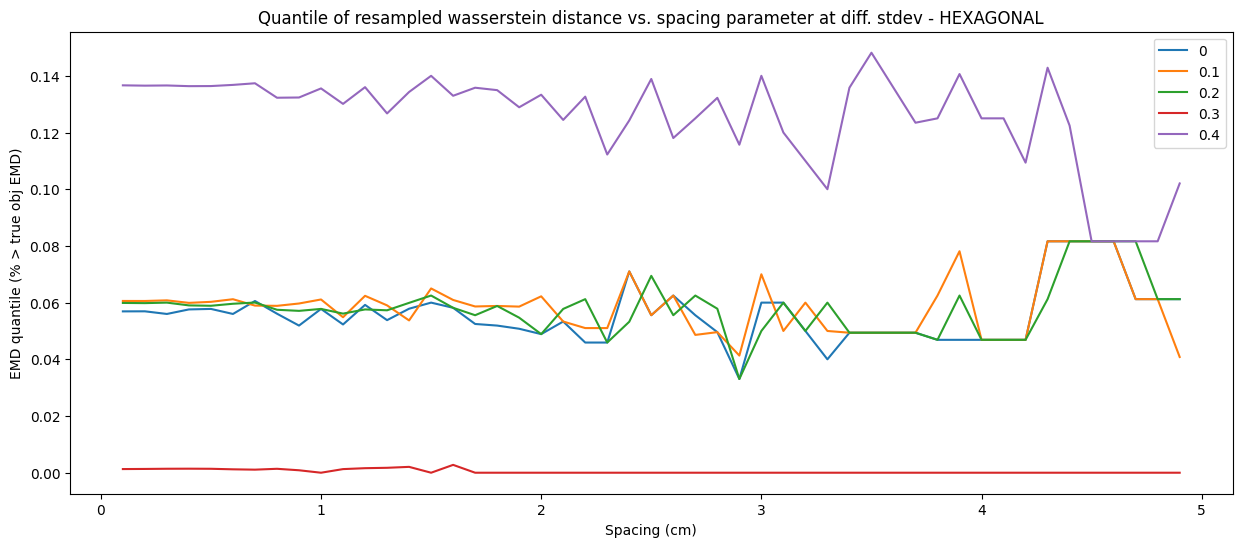

In [884]:
fig = plt.figure(figsize=(15,6))

for x in range(len(quantiles)):
    plt.plot(np.arange(.1,5,.1), quantiles[x], label=[0,.1,.2,.3,.4][x])
plt.legend()
plt.title('Quantile of resampled wasserstein distance vs. spacing parameter at diff. stdev - HEXAGONAL')
plt.xlabel('Spacing (cm)')
plt.ylabel('EMD quantile (% > true obj EMD)')
plt.show()

C:\Users\aaoun\AppData\Local\Temp\ipykernel_19204\2254540605.py:6: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000017C341DEB90>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([l1,l2], ['HEXAGONAL', 'RECTANGULAR'])
C:\Users\aaoun\AppData\Local\Temp\ipykernel_19204\2254540605.py:6: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000017C341DF310>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([l1,l2], ['HEXAGONAL', 'RECTANGULAR'])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


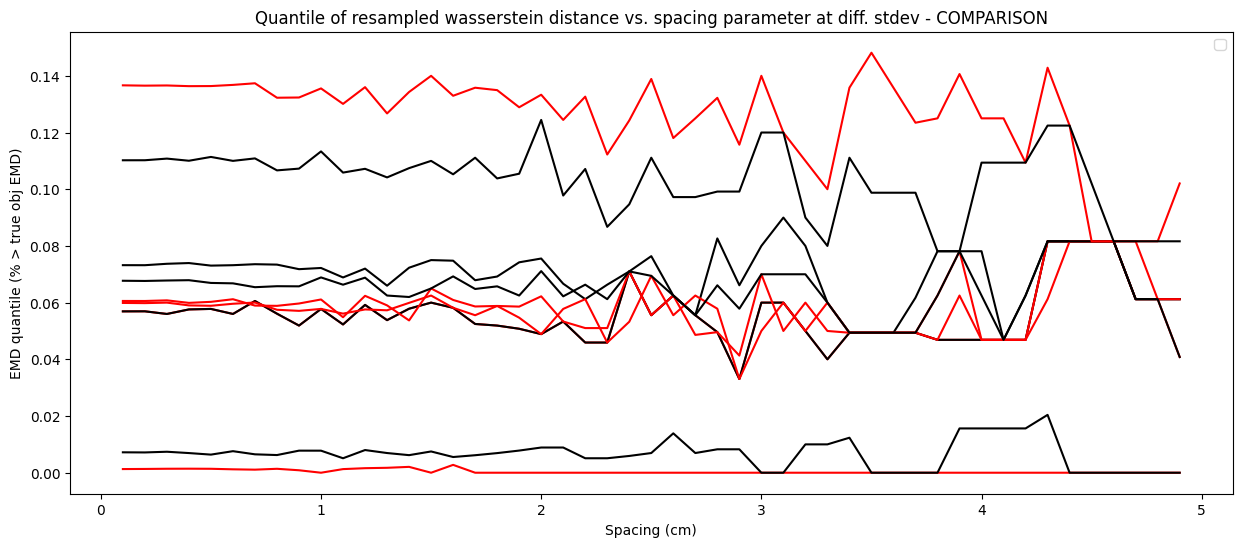

In [885]:
fig = plt.figure(figsize=(15,6))

for x in range(len(quantiles)):
    l1 = plt.plot(np.arange(.1,5,.1), quantiles[x], color='r')
    l2 = plt.plot(np.arange(.1,5,.1), rect_quantiles[x], color='k')
plt.legend([l1,l2], ['HEXAGONAL', 'RECTANGULAR'])
plt.legend()
plt.title('Quantile of resampled wasserstein distance vs. spacing parameter at diff. stdev - COMPARISON')
plt.xlabel('Spacing (cm)')
plt.ylabel('EMD quantile (% > true obj EMD)')
plt.show()

In [ ]:
rect_quantiles = [[] for i in np.arange(0,0.5,0.1)]
y , x = N, N
jx = 0
noises = []
for j in np.arange(0, 0.5, 0.1):
    noise = np.random.normal(0,j,circle_left_ex1.shape)
    source_field = circle_left_ex1 + noise
    noises.append(noise)
    source_field = np.pad(source_field, 2, mode='linear_ramp')
    r, c = np.where(source_field == np.max(source_field))
    object_pos = [r,c]
    obj_wass = single_point_wasserstein(object_pos, source_field, ([10],[10]))

    for i in np.arange(.1,5,.1):
        
        non_disk_ids = list(itertools.product(np.arange(0, y), np.arange(0, x)))
        # non_disk_grid_sample = _sample_grid(non_disk_ids, i)
        non_disk_grid_sample = generate_grid(30, 50, i, is_hexagonal=False)
        non_disk_grid_sample = np.asarray(non_disk_grid_sample)
        
        resampled_wass = list(map(lambda x: single_point_wasserstein(x, source_field, ([10],[10]), use_pos_directly=True), non_disk_grid_sample))
        quantile = (resampled_wass < obj_wass).mean()
        rect_quantiles[jx].append(quantile)

    jx += 1

fig = plt.figure(figsize=(15,6))

for x in range(len(rect_quantiles)):
    plt.plot(np.arange(.1,5,.1), rect_quantiles[x], label=[0,.1,.2,.3,.4][x])
plt.legend()
plt.title('Quantile of resampled wasserstein distance vs. spacing parameter at diff. stdev - RECTANGULAR')
plt.xlabel('Spacing (cm)')
plt.ylabel('EMD quantile (% > true obj EMD)')
plt.show()

In [177]:
quantiles = [[] for i in np.arange(0,0.5,0.1)]
y , x = N, N
jx = 0
for j in np.arange(0, 0.5, 0.1):
    source_field = circle_left_ex1 + noises[jx]
    # source_field = np.pad(source_field, 2, 'constant', constant_values=0)
    r, c = np.where(source_field == np.max(source_field))
    object_pos = [r,c]
    obj_wass = single_point_wasserstein(object_pos, source_field, ([1],[1]))

    for i in np.arange(0,5,0.2):
        
        non_disk_ids = list(itertools.product(np.arange(0, y), np.arange(0, x)))
        non_disk_grid_sample = _sample_grid(non_disk_ids, i)
        
        resampled_wass = list(map(lambda x: single_point_wasserstein(x, source_field, ([1],[1])), non_disk_grid_sample))
        quantile = (resampled_wass < obj_wass).mean()
        quantiles[jx].append(quantile)

    jx += 1

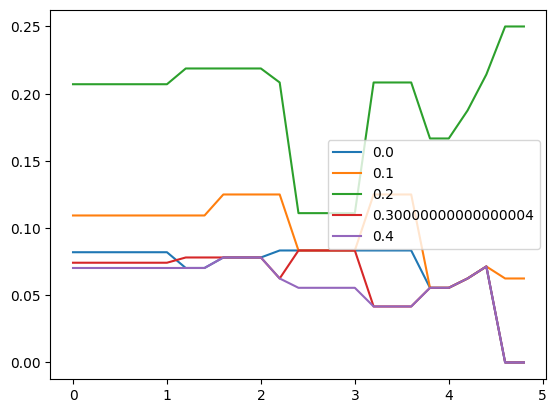

In [178]:
for x in range(len(quantiles)):
    plt.plot(np.arange(0,5,0.2), quantiles[x], label=np.arange(0,0.5,0.1)[x])
plt.legend()

(32, 32) [0 1 2]


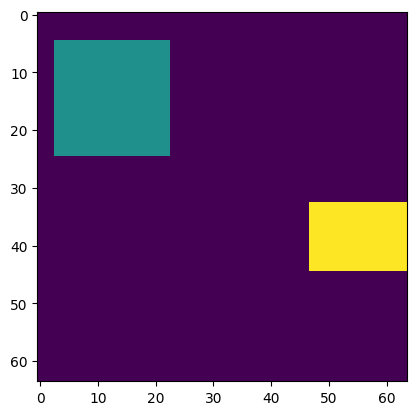

In [924]:
import skimage
import numpy as np
import cv2

testor = np.zeros((64,64))
testor[5:25,3:23] = 1
testor[33:45,47:] = 2
mask = testor
# plt.imshow(skimage.measure.block_reduce(testor, 2))
resizeto = 2
small_lable = cv2.resize(mask, (mask.shape[1]//resizeto, 
                         mask.shape[0]//resizeto),
                        interpolation=cv2.INTER_NEAREST)
small_lable = (np.array(small_lable)).astype('uint8')
print(small_lable.shape, np.unique(small_lable))
# plt.imshow(small_lable)
plt.imshow(testor)

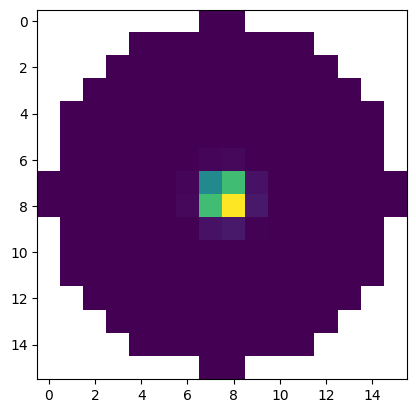

In [941]:
def _downsample(img, downsample_factor):
    downsampled = block_reduce(img, downsample_factor) 
    return downsampled
from skimage.measure import block_reduce

def disk_mask(matrix):
        y_segments, x_segments = matrix.shape

        y_center, x_center = (y_segments-1)/2, (x_segments-1)/2

        mask_r = min(x_segments, y_segments)/2

        mask_y,mask_x = np.ogrid[-y_center:y_segments-y_center, -x_center:x_segments-x_center]
        mask = mask_x**2 + mask_y**2 > mask_r**2

        masked_matrix = np.ma.array(matrix, mask=mask)

        return masked_matrix

def flat_disk_mask(rate_map):
    masked_rate_map = disk_mask(rate_map)
    # masked_rate_map.data[masked_rate_map.mask] = 0
    # masked_rate_map.data[masked_rate_map.mask] = np.nan
    # print(np.unique(masked_rate_map.data))
    # return  masked_rate_map.data
    copy = np.copy(rate_map).astype(np.float32)
    copy[masked_rate_map.mask] = np.nan
    return copy

N = 64
stdev = 3
px = np.arange(0,N,1)
py = np.arange(0,N,1)
mesh = np.meshgrid(px, py)

rx, ry = 2, 2
sx, sy = int(N/2), int(N/2)
rot = 90
circle_left_ex1 = make_gauss(mesh, [sx, sy], [rx, ry], np.deg2rad(-rot)) 

plt.imshow(_downsample(flat_disk_mask(circle_left_ex1), 4))

In [906]:
skimage.measure.block_reduce(circle_left_ex1, 2).shape

(8, 8)

In [905]:
circle_left_ex1.shape

(16, 16)